In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain, combinations
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 185 ms, sys: 915 ms, total: 1.1 s
Wall time: 1.48 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [7]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [8]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [9]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [10]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [11]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [12]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
seq_Rs_RSA_min_max = pd.read_csv('../holehouse_project/IDRome_Rs_RSA_min_max.csv').set_index('seq_name')

# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]


seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fpos'] = [(seq.count('K')+seq.count('R'))/len(seq) for seq in seq_name_AFRC.fasta.values]
seq_name_AFRC['fneg'] = [(seq.count('D')+seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']],
                              seq_Rs_RSA_min_max[['Rs_min','Rs_max','RSA_min','RSA_max']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS, seq_Rs_RSA_min_max
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,albatross_Ree,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range,Rs_min,Rs_max,RSA_min,RSA_max
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,4.138554,4.251985,0.578297,0.790029,7.039022,0.537698,0.394069,13.359064,0.020020,0.919532
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,3.321804,3.321804,0.498650,0.756501,7.359276,0.538843,0.362843,12.440695,0.005640,0.916947
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,5.670386,5.788718,0.544833,1.185494,7.414943,0.500908,0.141260,15.066551,0.009369,0.898853
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,7.614085,7.813105,0.504434,1.620033,8.038966,0.485090,0.126127,16.653733,0.005293,0.864358
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,4.691561,4.962079,0.566668,0.945399,6.813072,0.499202,0.233267,13.580518,0.032299,0.866482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,9.571439,9.803478,0.534929,2.045043,7.521686,0.492647,0.095092,15.142073,0.011525,0.893606
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,10.693898,10.582268,0.504626,2.664859,7.982766,0.519563,0.295461,17.727406,0.016098,0.887311
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,7.447835,7.863577,0.570739,1.685618,7.465008,0.516141,0.119394,15.193279,0.021437,0.911143
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,7.340392,7.289317,0.541635,1.597735,7.462810,0.493407,0.061003,14.613526,0.021912,0.902681


In [13]:
idrome_prop_flucs.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'AFRC_mean_rg_theta', 'rg_rg_theta_mean',
       'mean_inst_ratio', 'mean_RSA', 'fP', 'net_charge', 'fpos', 'fneg',
       'fC_shape_shape', 'fA_shape_shape', 'fC_size_shape', 'fA_size_shape',
       'bounded_frac_size_shape', 'Rg_std', 'Rs_std', 'RSA_std',
       'albatross_Rg', 'albatross_Rg_scaled', 'albatross_Ree',
       'albatross_Ree_scaled', 'albatross_scaling_exponent', 'Rg_range',
       'Rs_range', 'RSA_range', 'Rs_min', 'Rs_max', 'RSA_min', 'RSA_max'],
      dtype='object')

### DO NOT RUN the immediately below cell

In [16]:
#DO NOT run this cell
#these FOUR IDR simulations have low snapshots (<1000)
# %%time
# for seq_dir in seq_name_dir_df.seq_dir.values:
#     if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
#         print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420
23881    Q9Y2W1_1_611
Name: seq_name, dtype: object 100
27365    Q9BXT5_1_968
Name: seq_name, dtype: object 100
CPU times: user 3.77 s, sys: 2.96 s, total: 6.73 s
Wall time: 14min 48s


In [14]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

# random forest regressor model to predict mean RSA

In [26]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N',
                                                                               'fK','fR','fE','faro','kappa','fcr','z_omega_pi',
                                                                               'z_omega_+', 'z_omega_-', 'z_omega_h','fP'])]]
#y = idrome_prop_flucs['Rg/nm'].values**2/idrome_prop_flucs['N'].values
y = idrome_prop_flucs['mean_RSA']

In [27]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [28]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [29]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 16)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 16)
Testing Labels Shape: (7014,)


In [30]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 4min 4s, sys: 240 ms, total: 4min 4s
Wall time: 4min 5s


In [31]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


# predicted vs actual dataset

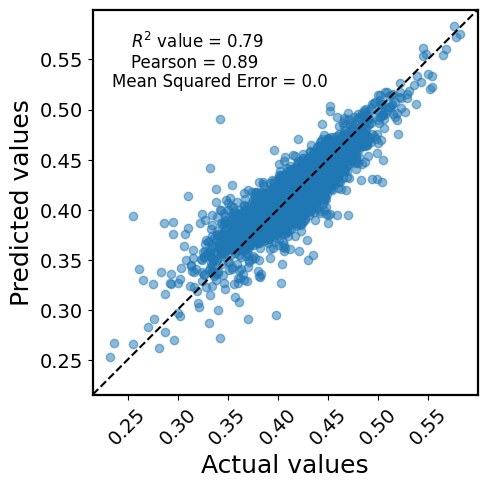

In [32]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [33]:
#get feature importance from model
feature_importances={"feature": [],"importance": []}
for i,j in zip(X.columns,rf.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

In [34]:
#convert to dataframe. Sort by importance. Add a category that classifies features as 'Lab' or 'ECFP'
feature_importances = pd.DataFrame(feature_importances).sort_values(by='importance',ascending=False).copy()
#feature_importances['feature_category'] = ['ECFP' if 'feat' in feature else 'Lab' for feature in feature_importances.feature.values]
#feature_importances = feature_importances.reset_index(drop=True).copy()

In [35]:
feature_importances

,feature,importance
5,shd,0.384833
6,scd,0.261699
15,net_charge,0.118137
9,z_delta_+-,0.035388
4,faro,0.032800
7,kappa,0.028184
2,fR,0.023736
12,z_omega_-,0.020020
0,N,0.015995
8,fcr,0.015112


In [36]:
del X,y

# random forest regressor model to predict stdev Rg

In [16]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N',
                                                                               'fK','fR','fE','faro','kappa','fcr','z_omega_pi',
                                                                               'z_omega_+', 'z_omega_-', 'z_omega_h','fP'])]]
y = idrome_prop_flucs['Rg_std']

In [17]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [18]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [19]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 16)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 16)
Testing Labels Shape: (7014,)


In [20]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 3min 32s, sys: 421 ms, total: 3min 33s
Wall time: 3min 33s


In [21]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.03
MSE: 0.0


# predicted vs actual dataset

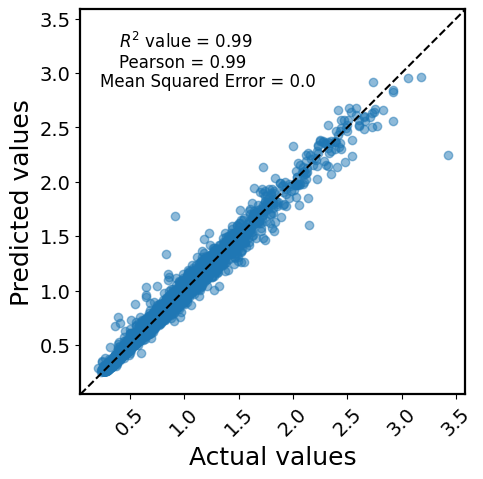

In [22]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [23]:
#get feature importance from model
feature_importances={"feature": [],"importance": []}
for i,j in zip(X.columns,rf.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

In [24]:
#convert to dataframe. Sort by importance. Add a category that classifies features as 'Lab' or 'ECFP'
feature_importances = pd.DataFrame(feature_importances).sort_values(by='importance',ascending=False).copy()
#feature_importances['feature_category'] = ['ECFP' if 'feat' in feature else 'Lab' for feature in feature_importances.feature.values]
#feature_importances = feature_importances.reset_index(drop=True).copy()

In [25]:
feature_importances

,feature,importance
0,N,0.982280
6,scd,0.002668
5,shd,0.002645
9,z_delta_+-,0.002147
4,faro,0.001362
2,fR,0.001205
7,kappa,0.001191
15,net_charge,0.001187
11,z_omega_+,0.000837
12,z_omega_-,0.000828


In [26]:
del X, y

# random forest regressor model to predict maximum Rs

In [26]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N','fpos','fneg',
                                                                               'fK','fR','fE','faro','kappa','fcr','z_omega_pi',
                                                                               'z_omega_+', 'z_omega_-', 'z_omega_h','fP'])]]
y = idrome_prop_flucs['Rs_max']

In [27]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [28]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [29]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 18)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 18)
Testing Labels Shape: (7014,)


In [30]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 4min 33s, sys: 219 ms, total: 4min 33s
Wall time: 4min 34s


In [31]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.87
MSE: 1.29


# predicted vs actual dataset

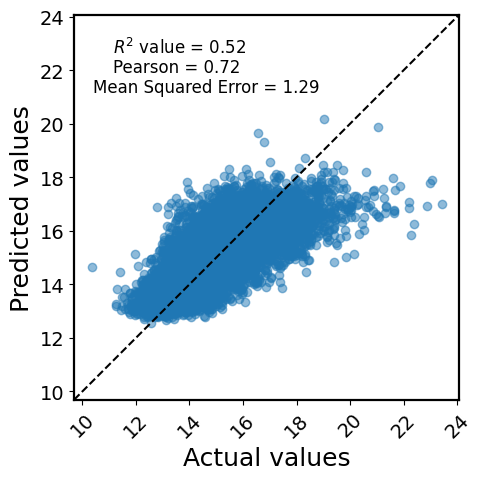

In [32]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [33]:
#get feature importance from model
feature_importances={"feature": [],"importance": []}
for i,j in zip(X.columns,rf.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

In [34]:
#convert to dataframe. Sort by importance. Add a category that classifies features as 'Lab' or 'ECFP'
feature_importances = pd.DataFrame(feature_importances).sort_values(by='importance',ascending=False).copy()
#feature_importances['feature_category'] = ['ECFP' if 'feat' in feature else 'Lab' for feature in feature_importances.feature.values]
#feature_importances = feature_importances.reset_index(drop=True).copy()

In [35]:
feature_importances

,feature,importance
0,N,0.513018
5,shd,0.058648
6,scd,0.039599
13,z_omega_h,0.036667
4,faro,0.035915
15,net_charge,0.034102
7,kappa,0.032537
14,fP,0.032327
2,fR,0.027598
3,fE,0.026479


In [36]:
del X, y

# random forest regressor model to predict mean Rg

In [38]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['Rg/nm']

In [39]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [40]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [41]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 7)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 7)
Testing Labels Shape: (7014,)


In [42]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

KeyboardInterrupt: 

In [43]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

IndexError: list index out of range

# predicted vs actual dataset

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [ ]:
#get feature importance from model
feature_importances={"feature": [],"importance": []}
for i,j in zip(X.columns,rf.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

In [ ]:
#convert to dataframe. Sort by importance. Add a category that classifies features as 'Lab' or 'ECFP'
feature_importances = pd.DataFrame(feature_importances).sort_values(by='importance',ascending=False).copy()
feature_importances['feature_category'] = ['ECFP' if 'feat' in feature else 'Lab' for feature in feature_importances.feature.values]
feature_importances = feature_importances.reset_index(drop=True).copy()

In [ ]:
feature_importances

## run model 6 times with different seed

CPU times: user 7min 11s, sys: 2.17 s, total: 7min 14s
Wall time: 7min 15s


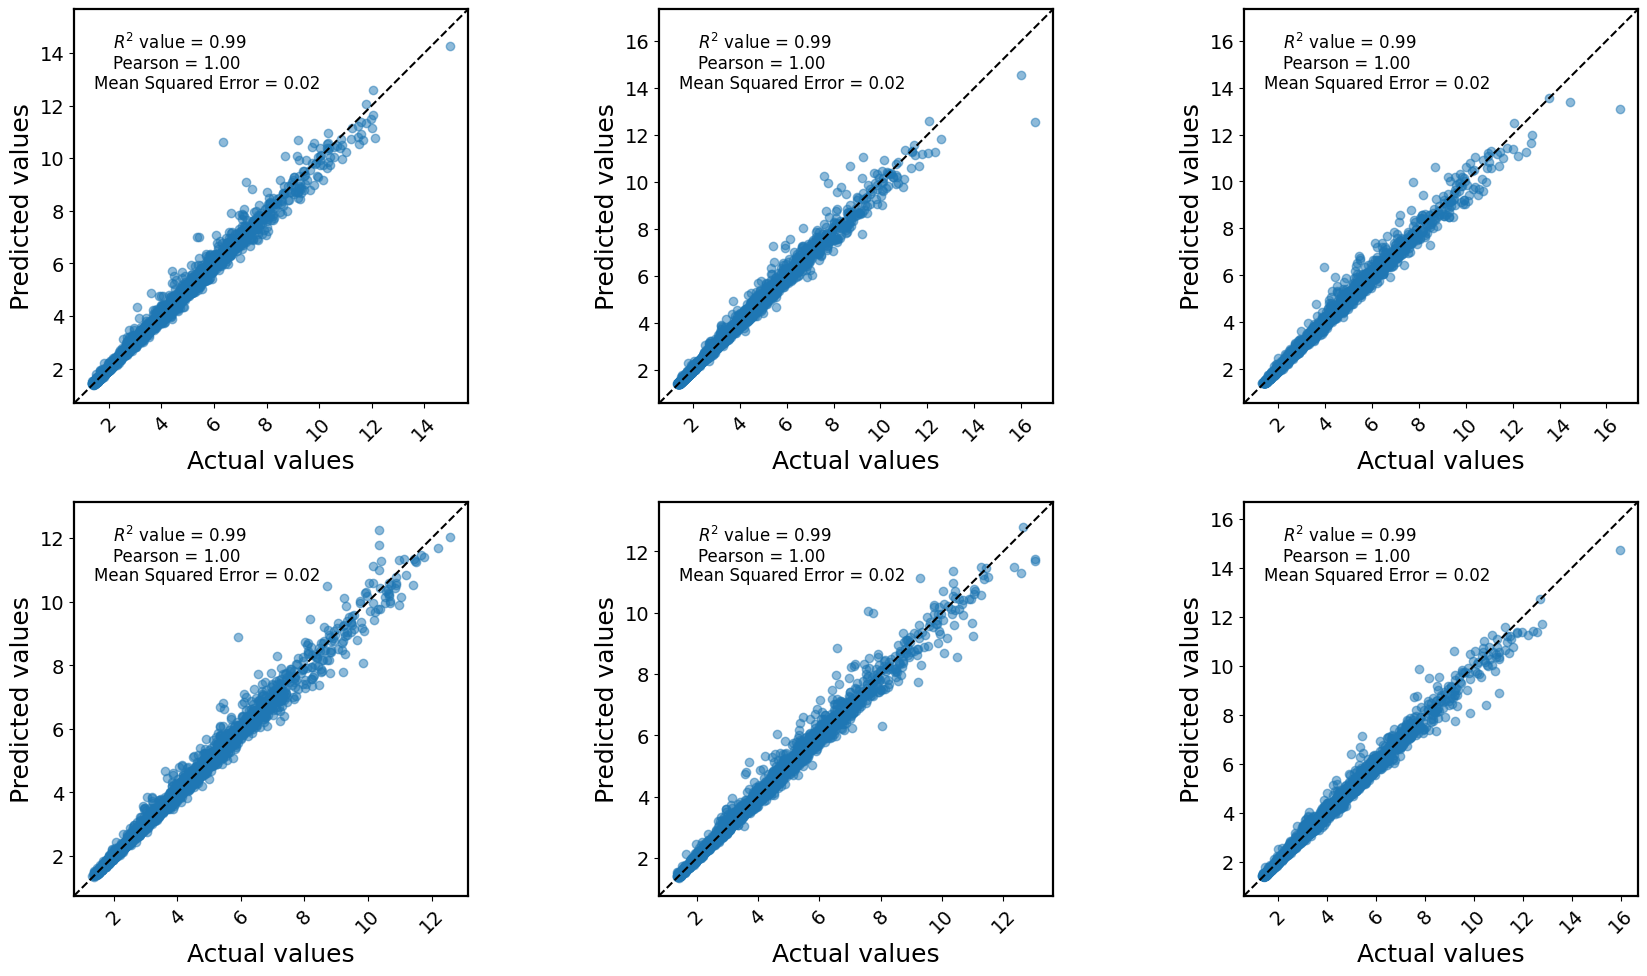

In [22]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [23]:
del X,y

# random forest regressor model to predict stdev of Rg

In [24]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['Rg_std']

In [25]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [26]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [27]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [28]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 13s, sys: 146 ms, total: 1min 14s
Wall time: 1min 14s


In [29]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.03
MSE: 0.0


# predicted vs actual dataset

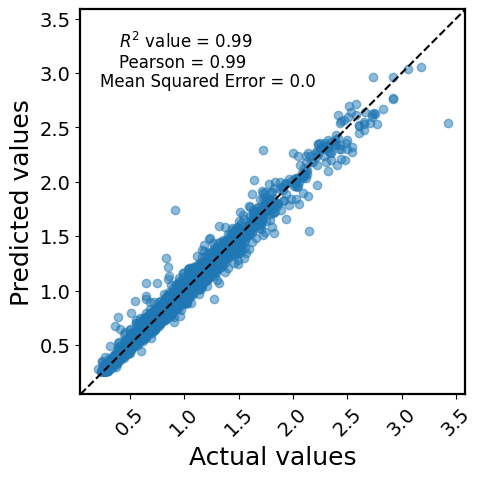

In [30]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [31]:
del X,y

# random forest regressor model to predict mean Ree

In [48]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['Ree/nm']

In [49]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [50]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [51]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [52]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 11s, sys: 292 ms, total: 1min 12s
Wall time: 1min 12s


In [53]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.2
MSE: 0.17


# predicted vs actual dataset

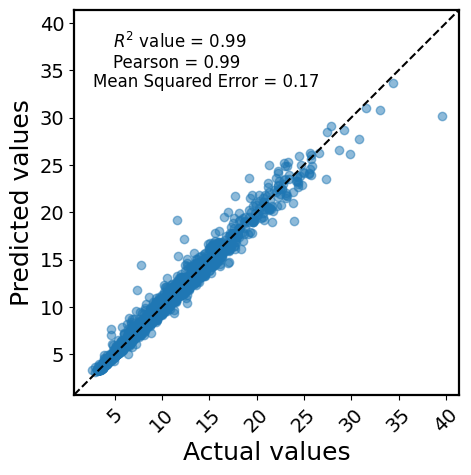

In [54]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [55]:
del X,y

# random forest regressor model to predict mean Rs

In [52]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N','rg_rg_theta_mean'])]]
y = idrome_prop_flucs['mean_inst_ratio']

In [54]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [55]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [56]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 6)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 6)
Testing Labels Shape: (7014,)


In [57]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 53s, sys: 202 ms, total: 1min 53s
Wall time: 1min 53s


In [58]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.16
MSE: 0.05


# predicted vs actual dataset

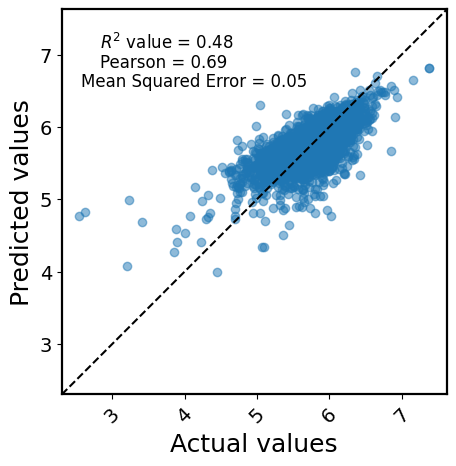

In [59]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [60]:
del X,y

# random forest regressor model to predict stdev of Rs

In [50]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['Rs_std']

In [51]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [52]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [53]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [54]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [55]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.09
MSE: 0.02


# predicted vs actual dataset

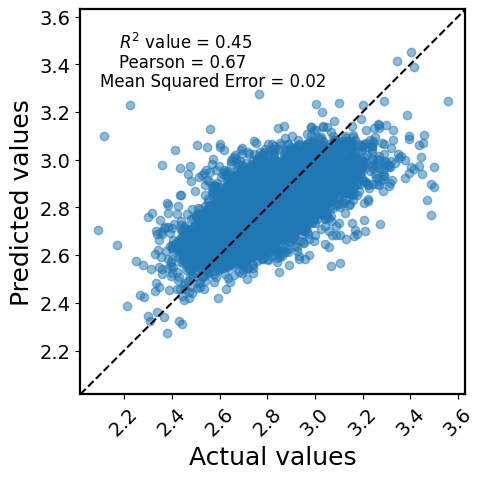

In [56]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [57]:
del X, y

# random forest regressor model to predict mean of RSA

In [58]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['mean_RSA']

In [59]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [60]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [61]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [62]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [63]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


# predicted vs actual dataset

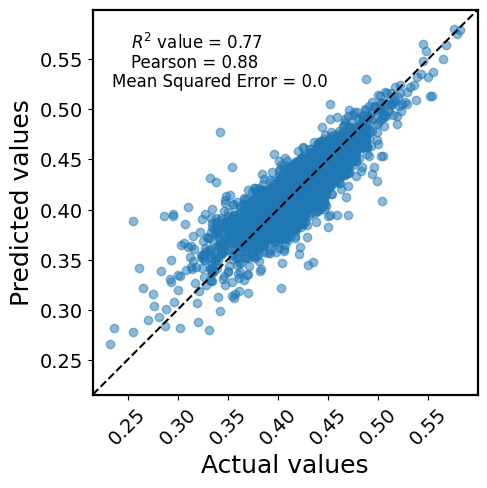

In [64]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [65]:
del X,y

# random forest regressor model to predict stdev of RSA

In [66]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['RSA_std']

In [67]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [68]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [69]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [70]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 46s, sys: 185 ms, total: 1min 46s
Wall time: 1min 46s


In [71]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.0
MSE: 0.0


# predicted vs actual dataset

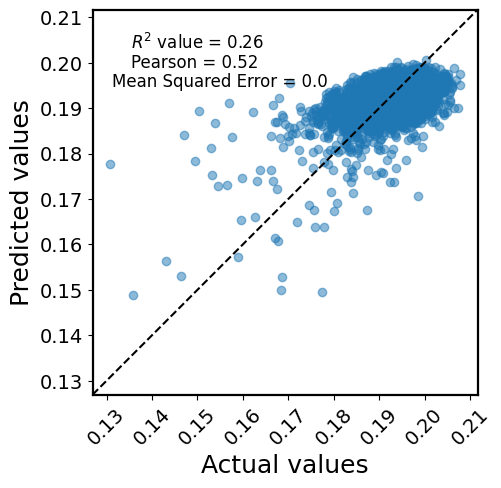

In [72]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [73]:
del X,y

# random forest regressor model to predict fC

In [74]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['fC_size_shape']

In [75]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [76]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [77]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [78]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 33s, sys: 212 ms, total: 1min 33s
Wall time: 1min 34s


In [79]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


# predicted vs actual dataset

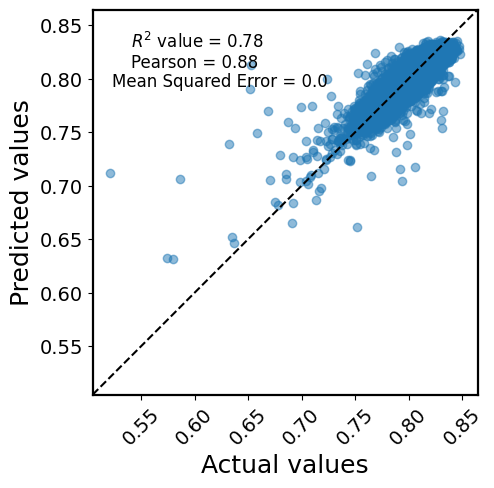

In [80]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [81]:
del X,y

# random forest regressor model to predict nu

In [88]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[idrome_prop_flucs.columns.isin(['shd','scd','net_charge','z_delta_+-','N'])]]
y = idrome_prop_flucs['nu']

In [89]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [90]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [91]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 5)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 5)
Testing Labels Shape: (7014,)


In [92]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 25s, sys: 230 ms, total: 1min 25s
Wall time: 1min 25s


In [93]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


# predicted vs actual dataset

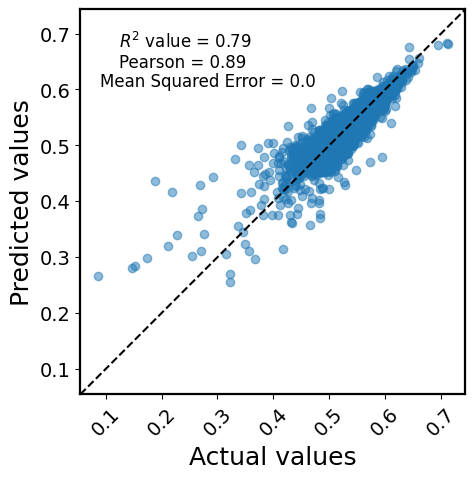

In [94]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [95]:
del X,y

# attempt to use feature hashing

# feature hashing combined with random forest model to predict mean Rs

In [32]:
from sklearn.feature_extraction.text import HashingVectorizer



sequences = idrome_prop_flucs['fasta'].values

# Creating a feature hasher
vectorizer = HashingVectorizer(n_features=2**10, analyzer='char', ngram_range=(3,3))

# Apply feature hashing
X = vectorizer.fit_transform(sequences).toarray()

print(X.shape)



(28054, 1024)


In [33]:
y = idrome_prop_flucs['mean_inst_ratio']

In [34]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [35]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [36]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21040, 1024)
Training Labels Shape: (21040,)
Testing Features Shape: (7014, 1024)
Testing Labels Shape: (7014,)


In [37]:
test_set = pd.read_csv('test_features-sequence_features_ML_predict_mean_inst_ratio.csv')
train_set = pd.read_csv('train_features-sequence_features_ML_predict_mean_inst_ratio.csv')

# predicted vs actual dataset

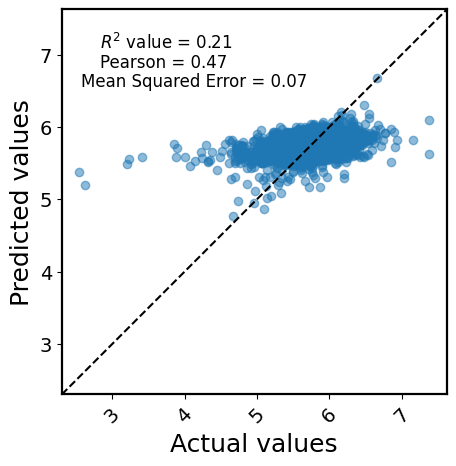

In [38]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,test_set.test_predictions.values
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

In [39]:
del X,y